# Data Science Project - TIM

## Brief description of the project 

scrivi che progetto è:

Progetto di predizione per assicurazione della macchina

scrivi i passaggi:
1. carico dati
2. preprocess
3. bilanciamento del dataset
4. addestramento e confronto di diversi modelli di classificazione
5. valutazione dei risultati e scelta del miglior modello
6. predizioni su un test set

scrivi readme

scrivi requirements

check github

## Import Libraries

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

## Import Data

In [138]:
train = pd.read_csv("data/train/train_auto.csv",index_col="INDEX")
test = pd.read_csv("data/test/test_auto.csv",index_col="INDEX")

Let's take a look at the dataset

In [139]:
train

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,0,0.0,0,35.0,0,11.0,"$43,112",No,$0,z_No,...,"$27,330",10,Panel Truck,yes,$0,0,No,0,8.0,z_Highly Rural/ Rural
10298,0,0.0,1,45.0,2,9.0,"$164,669",No,"$386,273",Yes,...,"$13,270",15,Minivan,no,$0,0,No,2,17.0,Highly Urban/ Urban
10299,0,0.0,0,46.0,0,9.0,"$107,204",No,"$332,591",Yes,...,"$24,490",6,Panel Truck,no,$0,0,No,0,1.0,Highly Urban/ Urban


Let's remove the variable 'TARGET_AMT' as it is correlated with 'TARGET_FLAG' and would affect the results. I assumed that 'TARGET_AMT' it's linked directly to the class vector. Moreover 'TARGET_AMT' and 'TARGET_FLAG' are null in testset. 

In [140]:
train[['TARGET_FLAG','TARGET_AMT']].corr()

,TARGET_FLAG,TARGET_AMT
TARGET_FLAG,1.000000,0.534246
TARGET_AMT,0.534246,1.000000


In [141]:
# Remove TARGET_AMT
train.drop(['TARGET_AMT'], axis=1, inplace=True)

# Remove Null variables from test data
test.drop(['TARGET_FLAG','TARGET_AMT'], axis=1, inplace=True)

## Feature Engineering

### Check features' type

Study what features are contained in the dataset

In [142]:
# Obtain a pandas series containing features data types
result = pd.DataFrame(train.dtypes, columns=['Type'])
result.reset_index(inplace=True, names=['Features'])
result.groupby(['Type']).count()

,Features
Type,
int64,7
float64,3
object,14


Since there are mixed features, we should convert the categorical features and strings into a numeric form

Find categorical variables


In [143]:
catVars = result.loc[result['Type'] == "object"]
catVars

,Features,Type
5,INCOME,object
6,PARENT1,object
7,HOME_VAL,object
8,MSTATUS,object
9,SEX,object
10,EDUCATION,object
11,JOB,object
13,CAR_USE,object
14,BLUEBOOK,object
16,CAR_TYPE,object


### Convert strings into numeric 

Convert INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM into numerical

If we check the dataset we can see that the variables [INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM] are numerical variables. However they are considered as strings because in the .csv they are represented as, for example, INCOME = "$20,000". We can convert them in a numerical form.


In [144]:
# Define a function that extract the numerical value from a string like '$200' and convert it to an int
def str2int(df, variables):
    # c is an index that tell if a conversion was made
    c = 0
    # Create a copy of the original dataframe to avoid warnings
    newdf = df.copy()
    for var in variables:
        if df[var].dtypes == 'object': 
            newdf[var] = df[var].apply(lambda x: float(x.split("$")[1].replace(",","")) if type(x) == str else x)
            print("Variable " + var + " was converted!")
            c = 1
        else: # if variable was converted already its tipe will be float64
            print("Variable " + var + " is not categorical")
    # Return an output  
    if c == 1:
        return newdf
    else: 
        return df

In [145]:
train = str2int(train, ["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM"])
test = str2int(test, ["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM"])

Variable INCOME was converted!
Variable HOME_VAL was converted!
Variable BLUEBOOK was converted!
Variable OLDCLAIM was converted!
Variable INCOME was converted!
Variable HOME_VAL was converted!
Variable BLUEBOOK was converted!
Variable OLDCLAIM was converted!


### Fill NaN

Before rebalancing the dataset and dummifying the categorical variables, the NaN values must be filled to avoid problems during training.
In this case I simply replaced the NaN values of numerical and categorical variables with mean and modal values respectively.

In [146]:
train.isna().sum()

TARGET_FLAG      0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

In [147]:
vars = train.columns.drop('TARGET_FLAG')
for var in vars: 
    # TRAIN
    if any(train[var].isna()):
        if train[var].dtypes == 'float64':
            # substitute NaN with mean
            train[var].fillna(value=train[var].mean(), 
                                 inplace=True)
        elif train[var].dtypes == 'object':
            # substitute NaN with mode
            train[var].fillna(value=train[var].mode()[0], 
                                inplace=True)        
    # TEST
    if any(test[var].isna()):
        if test[var].dtypes == 'float64':
            # substitute NaN with mean
            test[var].fillna(value=train[var].mean(), 
                               inplace=True)
        elif test[var].dtypes == 'object':
            # substitute NaN with mode
            a = train[var].mode()
            test[var].fillna(value=train[var].mode()[0],
                                inplace=True)

Check if there is still some NaN value

In [148]:
train.isna().sum()

TARGET_FLAG    0
KIDSDRIV       0
AGE            0
HOMEKIDS       0
YOJ            0
INCOME         0
PARENT1        0
HOME_VAL       0
MSTATUS        0
SEX            0
EDUCATION      0
JOB            0
TRAVTIME       0
CAR_USE        0
BLUEBOOK       0
TIF            0
CAR_TYPE       0
RED_CAR        0
OLDCLAIM       0
CLM_FREQ       0
REVOKED        0
MVR_PTS        0
CAR_AGE        0
URBANICITY     0
dtype: int64

### Scale continuous variables
Standardize data

In [149]:
from sklearn.preprocessing import StandardScaler

def scaling(traindf, testdf, catVars):
    # setup scaler
    scaler = StandardScaler()
    train_s = traindf.copy()
    test_s = testdf.copy()
    # remove flag from the df
    catVarsTest = catVars.copy()
    # I will remove both the target variables because in test data they're not provided
    catVars = catVars + ['TARGET_FLAG']
    train_s.drop(catVars, axis=1, inplace=True)
    test_s.drop(catVarsTest, axis=1, inplace=True)
    # training set scaling
    train_s = pd.DataFrame(scaler.fit_transform(train_s), 
                               columns=train_s.columns, index=train_s.index)
    # test set scaling
    test_s = pd.DataFrame(scaler.transform(test_s),
                          columns=test_s.columns, index=test_s.index)
    train_s = train_s.join(traindf[catVars])
    test_s = test_s.join(testdf[catVarsTest])

    return train_s, test_s

[train_s,test_s] = scaling(train, test, ['PARENT1', 'MSTATUS', 'RED_CAR', 'REVOKED',
             'SEX','CAR_USE','URBANICITY','JOB','CAR_TYPE','EDUCATION'])

### Convert categorical variables into dummy variables
We should PARENT1, MSTATUS, SEX, EDUCATION, JOB, CAR_USE, CAR_TYPE, RED_CAR, REVOKED, URBANICITY into dummy variables.
Using the following code:

    train_c.groupby(['VARIABLE']).count().index

We found the following categories:

<ul>
  <li>PARENT1 = ['No','Yes']</li>
  <li>MSTATUS = ['No','Yes']</li>
  <li>RED_CAR = ['no','yes']</li>
  <li>REVOKED = ['No','Yes']</li>
  <li>SEX = ['M','z_F']</li>
  <li>EDUCATION = ['<'High School', 'Bachelors', 'Masters', 'PhD', 'z_High School']</li>
  <li>JOB = ['Clerical', 'Doctor', 'Home Maker', 'Lawyer', 'Manager', 'Professional','Student', 'z_Blue Collar']</li>
  <li>CAR_USE = ['Commercial', 'Private']</li>
  <li>CAR_TYPE = ['Minivan', 'Panel Truck', 'Pickup', 'Sports Car', 'Van', 'z_SUV']</li>
  <li>CAR_USE = ['Commercial', 'Private']</li>
  <li>URBANICITY = ['Highly Urban/ Urban', 'z_Highly Rural/ Rural']</li>
</ul>	

We can convert PARENT1, MSTATUS, RED_CAR, REVOKED, SEX, CAR_USE, URBANICITY into a binary numeric variable and the other variables into more dummy variables. 

In [150]:
def convertCategorical(train_s):
    catVar = ['PARENT1', 'MSTATUS', 'RED_CAR', 'REVOKED']
        
    # Convert binary yes/no variables to dummies
    train_c = yncat2int( train_s, catVar)
    
    # Convert the other categorical binary variables
    if 'SEX' in train_c.columns:
        train_c['GENDER'] = train_s['SEX'].apply(lambda x: 1 if 'M' in x else 0)
        train_c.drop(['SEX'],axis=1,inplace=True)

    if 'CAR_USE' in train_c.columns:
        train_c['COMMERCIAL_CAR_USE'] = train_s['CAR_USE'].apply(lambda x: 1 if 'commercial' in x.lower() else 0)
        train_c.drop(['CAR_USE'],axis=1,inplace=True)

    if 'URBANICITY' in train_c.columns:
        train_c['URBAN_CAR'] = train_s['URBANICITY'].apply(lambda x: 1 if 'urban' in x.lower() else 0)
        train_c.drop(['URBANICITY'],axis=1,inplace=True)

    # Convert multicategorical variables
    if 'EDUCATION' in train_c.columns:
        train_c['EDUCATION'] = train_c['EDUCATION'].apply(lambda x: 'Elementary Education' if '<high school' in x.lower() else x)
        # Insert dummy variables and Drop the original variable
        train_c = train_c.join(pd.get_dummies(train_c.EDUCATION.str.upper())).drop(['EDUCATION'],axis=1)
    if 'JOB' in train_c.columns:
        train_c = train_c.join(pd.get_dummies(train_c.JOB.str.upper())).drop(['JOB'],axis=1)
    if 'CAR_TYPE' in train_c.columns:
        train_c = train_c.join(pd.get_dummies(train_c.CAR_TYPE.str.upper())).drop(['CAR_TYPE'],axis=1)

    # make some names more understandable
    train_c.columns = train_c.columns.str.replace("Z_","")
    train_c.columns = train_c.columns.str.replace(" ","_")
        
    return train_c

# convert yes/no categorical variables to int
def yncat2int(df, variables):
    # Convert categorical variables to numerical
    c = 0 # c is an index that tell if a conversion was made
    # Create a copy of the original dataframe to avoid warnings
    newdf = df.copy()
    firstidx = df.index[0]
    for var in variables:
        if type(df[var][firstidx]) == str:
            newdf[var] = df[var].apply(lambda x: 1 if 'yes' in x.lower() else 0)
            #print("Variable " + var + " was converted!")
            c = 1
        else:
            # if we run the code again it will work fine
            print("Variable " + var + " is not categorical")
    # Return an output  
    if c == 1:
        return newdf
    else: 
        return df
    
train_c = convertCategorical(train_s)
test_c = convertCategorical(test_s)

## Export dataset


If desired, the new dataset can be exported

In [151]:
train_c.to_csv('data/train/train_cleaned.csv')  
test_c.to_csv('data/test/test_cleaned.csv')  

## Data Exploration

### Check variables correlation
By studying the correlation between the variables we can see that they are only poorly correlated.
There are only a few moderate correlations, for example between PhD and Doctor, between Lawyer and Master or between Gender and SUV.

<AxesSubplot: >

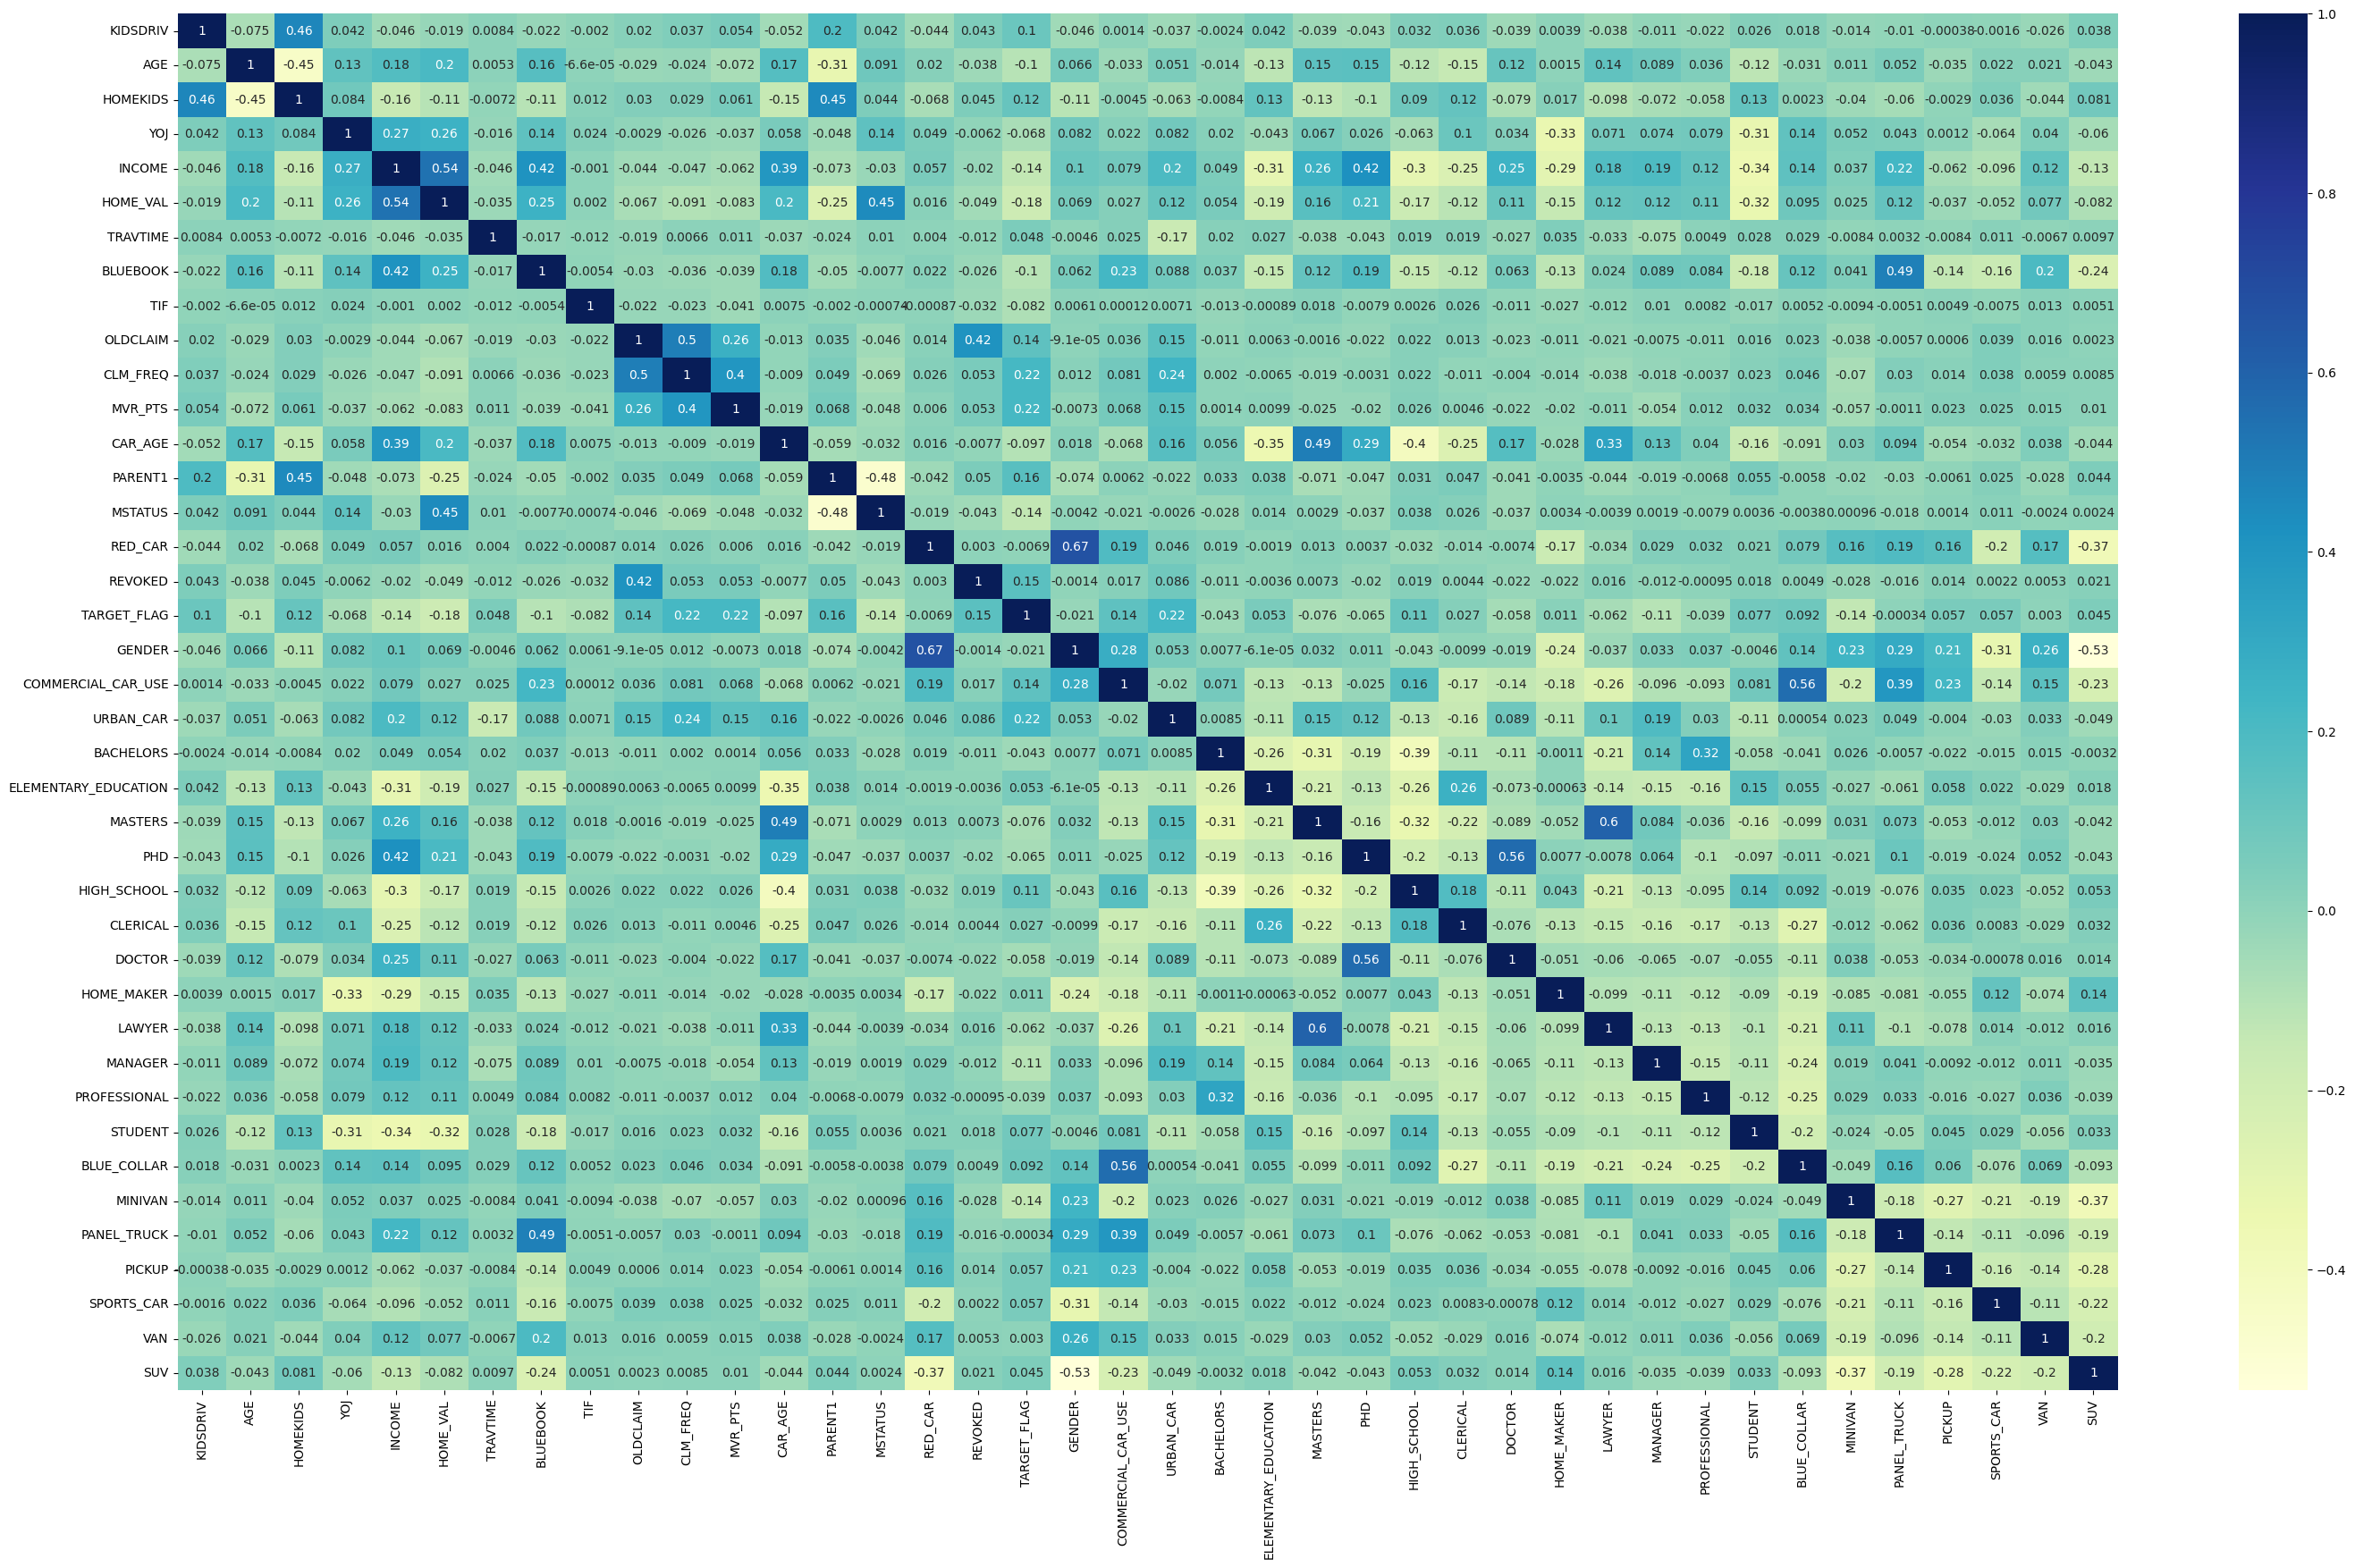

In [183]:
plt.figure(figsize=(35,20))
sns.heatmap(train_c.corr(), annot=True, cmap='YlGnBu')

### Scatterplot and boxplot

We can create a scatterplot of the variables, but they are quite confusing.

In [187]:
train_c.columns

Index(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME',
       'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE',
       'PARENT1', 'MSTATUS', 'RED_CAR', 'REVOKED', 'TARGET_FLAG', 'GENDER',
       'COMMERCIAL_CAR_USE', 'URBAN_CAR', 'BACHELORS', 'ELEMENTARY_EDUCATION',
       'MASTERS', 'PHD', 'HIGH_SCHOOL', 'CLERICAL', 'DOCTOR', 'HOME_MAKER',
       'LAWYER', 'MANAGER', 'PROFESSIONAL', 'STUDENT', 'BLUE_COLLAR',
       'MINIVAN', 'PANEL_TRUCK', 'PICKUP', 'SPORTS_CAR', 'VAN', 'SUV'],
      dtype='object')

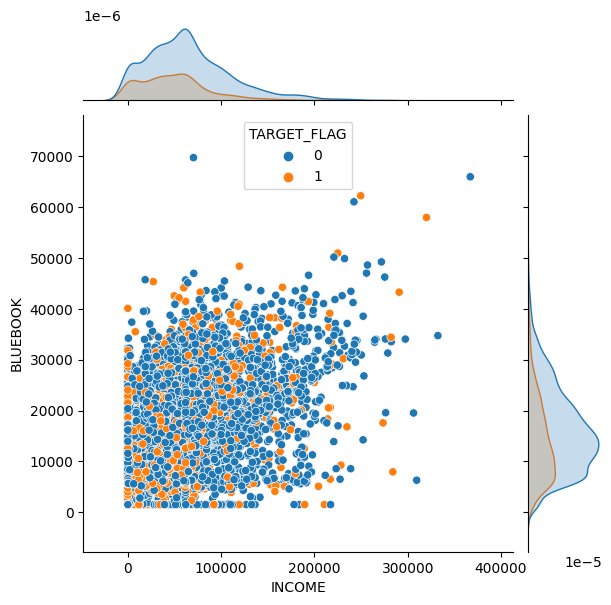

In [190]:
sns.jointplot(data=train, x="INCOME", y="BLUEBOOK", hue="TARGET_FLAG") # use train_c instead of train to see scaled data

In alternative, we can make some boxplot of the variables

<AxesSubplot: xlabel='TARGET_FLAG', ylabel='INCOME'>

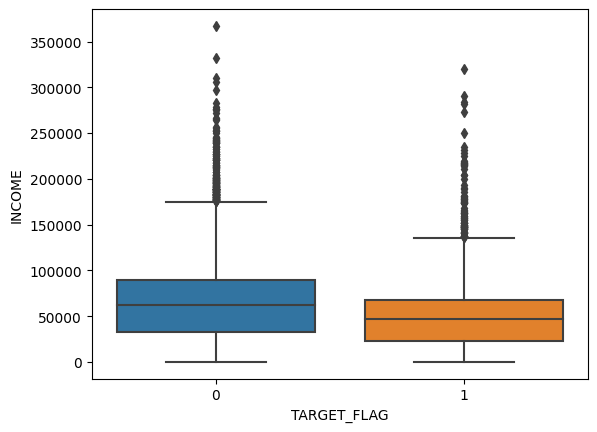

In [191]:
sns.boxplot(data=train, x="TARGET_FLAG", y="INCOME")

## Balancing dataset

As we can see, the dataset is very unbalanced and we have to use a resampling technique to get better performance

<AxesSubplot: title={'center': 'Unbalanced classes'}>

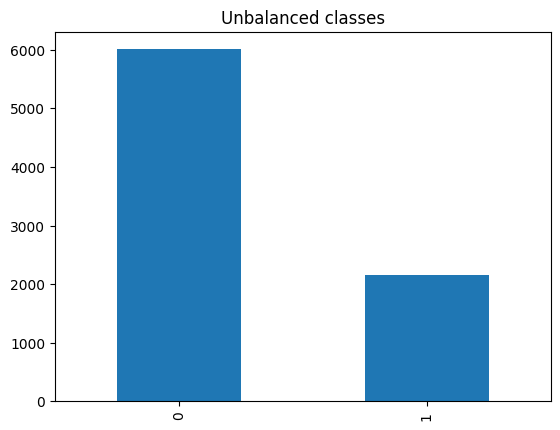

In [154]:
train_c['TARGET_FLAG'].value_counts().plot(kind='bar', title='Unbalanced classes')

I chose to use three different resampling techniques and then compare them in training to see which gives better results

In [155]:
from imblearn.over_sampling import SMOTE

# Balancing techniques
class_0_count, class_1_count = train_c['TARGET_FLAG'].value_counts()

imbSet = train_c.copy() 
class_0 = imbSet[imbSet['TARGET_FLAG'] == 0]
class_1 = imbSet[imbSet['TARGET_FLAG'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

# Random undersample of the majority class
class_0_under = class_0.sample(class_1_count)
train_under = pd.concat([class_0_under, class_1], axis=0)

# Random oversampling of the minority class
class_1_over = class_1.sample(class_0_count, replace = True)
train_over = pd.concat([class_1_over, class_0], axis=0)

# SMOTE
smote = SMOTE()
train_b = train_c.copy()
y = train_b['TARGET_FLAG']
train_b.drop('TARGET_FLAG', axis=1, inplace=True)
train_smote, y_sm = smote.fit_resample(train_b, y)
train_smote['TARGET_FLAG'] = y_sm

print("total class of 1 and 0:\n",train_under['TARGET_FLAG'].value_counts())# plot the count after under-sampeling
print("total class of 1 and 0:\n",train_over['TARGET_FLAG'].value_counts())# plot the count after under-sampeling
print("total class of 1 and 0:\n",train_smote['TARGET_FLAG'].value_counts())# plot the count after under-sampeling

trainData = train_smote.copy()

class 0: (6008, 40)
class 1: (2153, 40)
total class of 1 and 0:
 0    2153
1    2153
Name: TARGET_FLAG, dtype: int64
total class of 1 and 0:
 1    6008
0    6008
Name: TARGET_FLAG, dtype: int64
total class of 1 and 0:
 0    6008
1    6008
Name: TARGET_FLAG, dtype: int64


## Training models

Train different models and compare them

In [156]:
def classify(df):
    df['TARGET_FLAG'].value_counts()
    trainData = df.copy()
    # extract numerical values and label
    if 'TARGET_FLAG' in trainData.columns:
        ClassVector = trainData['TARGET_FLAG']
        trainData.drop('TARGET_FLAG', axis=1, inplace=True)

    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(trainData, ClassVector, test_size = 0.2, random_state = 0)
    
    # train a classification model 
    svm_rbf = svm.SVC()
    dt = DecisionTreeClassifier()
    nn = MLPClassifier(solver='adam', max_iter=800, hidden_layer_sizes=(10, 2), random_state=1)
    rf = RandomForestClassifier()

    # fit the models
    f1svm = trainMdl(svm_rbf,X_train,y_train,X_test,y_test)
    f1dt = trainMdl(dt,X_train,y_train,X_test,y_test)
    f1nn = trainMdl(nn,X_train,y_train,X_test,y_test)
    f1rf = trainMdl(rf,X_train,y_train,X_test,y_test)

    f1Df = pd.DataFrame([[f1svm, f1dt, f1rf, f1nn]], columns=['SVM','DT','RF','NN'])
    return f1Df

def trainMdl(mdl,X_train,y_train,X_test,y_test):
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    return f1_score(y_test, y_pred)

Compare resampled datasets and the original one

In [157]:
f1Ori = classify(train_c)
f1under = classify(train_under)
f1over = classify(train_over)
f1smote = classify(train_smote)

Compare F1-scores

In [158]:
f1df= pd.concat([f1Ori, f1under, f1over, f1smote])
f1df.index = ['Original Data','UnderSample','OverSample','SMOTE']
f1df

,SVM,DT,RF,NN
Original Data,0.479760,0.429733,0.473846,0.539355
UnderSample,0.727689,0.612394,0.718067,0.708286
OverSample,0.797702,0.866822,0.910802,0.761218
SMOTE,0.840246,0.776545,0.863200,0.826412


Find the best performing model

In [159]:
bestf1 = f1df.to_numpy().max()
positionBest = f1df == bestf1
# find the columns containing True 
seriesObj = positionBest.any()
# find best model
bestMdl = seriesObj.index[seriesObj == True].tolist() 
bestPreproc = positionBest.index[positionBest[bestMdl[0]] == True].tolist()
print(bestMdl[0] + ' classifier with ' +  bestPreproc[0] + ' preprocessing achieved the best F1-Score of ' + str(bestf1))

RF classifier with OverSample preprocessing achieved the best F1-Score of 0.9108019639934534


Tune the best classifier

In [160]:
# set grid
param_grid = { 
    'n_estimators': [100, 200, 300],
}
trainData = train_over.copy()
# extract numerical values and label
if 'TARGET_FLAG' in trainData.columns:
    ClassVector = trainData['TARGET_FLAG']
    trainData.drop('TARGET_FLAG', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(trainData, ClassVector, test_size = 0.2, random_state = 0)
# Perform frid search
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='f1_macro')
CV_rfc.fit(X_train, y_train)
# print best results
print(CV_rfc.best_params_)
print('Mean CV results: ' + str(CV_rfc.cv_results_['mean_test_score']))

{'n_estimators': 100}
Mean CV results: [0.88906481 0.88687996 0.8883273 ]


## Evaluate model

Evaluate model with test data, plot confusion matrix and ROC curve

Accuracy on test data:  0.9072379367720466
F1-Score on test data:  0.9084940500615512


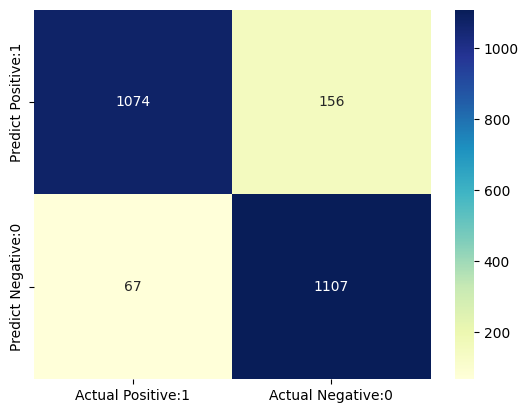

In [161]:
mdl = RandomForestClassifier(n_estimators=CV_rfc.best_params_['n_estimators'])
mdl.fit(X_train, y_train)
y_pred=mdl.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test,y_pred))
print("F1-Score on test data: ",f1_score(y_test,y_pred))
# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                         index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Plot ROC curve

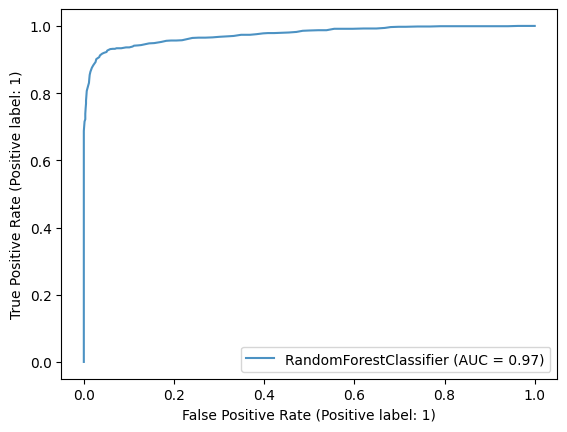

In [162]:
from sklearn.metrics import RocCurveDisplay
svc_disp = RocCurveDisplay.from_estimator(mdl, X_test, y_test, alpha=0.8)

## Prediction

Make a prediction for new data and export the results to a .csv file

In [163]:
# Export predictions, index and class probabilities

# select index
idx = test_c.index.to_list()
# predict class
ypred_test = pd.DataFrame(mdl.predict(test_c))
ypred_test.columns = ['predictions']
# predict probabilities
y_pred_prob_test = mdl.predict_proba(test_c)
# select probability for the selected class
max_probab = pd.DataFrame(y_pred_prob_test.max(axis=1))
max_probab.columns = ['probabilities']
idx = pd.DataFrame(idx)
idx.columns = ['idx']
# create a data frame
predResults = pd.concat([idx, ypred_test, max_probab], axis=1)
predResults.set_index('idx',inplace = True)
# export results
predResults.to_csv('predictionResults.csv')  
predResults

,predictions,probabilities
idx,,
3,0,0.72
9,0,0.51
10,0,0.90
18,0,0.81
21,0,0.71
...,...,...
10279,1,0.62
10281,0,0.95
10285,0,0.95
